# Pumping Test Evaluation - Hantush semi-confined aquifer

*Notebook by Tanja Liesch partly based on code by Prof.dr.ir.T.N.Olsthoorn: https://transientgroundwaterflow.readthedocs.io/en/latest/WellInLeakyAquifer.html*

## The Theis equation
The _drawdown_ $s$ at a distance $r$ from a well at time $t$ from which water is being pumped at a constant rate, $Q$, can be modelled using the _Theis_ equation,
$$
s(u) = \frac{Q}{4\pi T}W(u), \quad \mathrm{where}\quad u = \frac{r^2S}{4Tt}
$$
Here $S$ is the aquifer storage coefficient (volume of water released per unit decrease in $H$ per unit area) and $T$ is the transmissivity (a measure of how much water is transported horizontally per unit time). The _Well Function_, $W(u)$ is simply the exponential integral, $E_1(u).$


## Modification of Hantush and Walton for semi-confined aquifers
In a semi-confined aquifer, the Theis Well function is not only dependent on $u$, but also on $r/B$, where $B$ is the so called Leakage factor:

$$
s = \frac{Q}{4\pi T}W(u, r/B), \quad \mathrm{where}\quad u = \frac{r^2S}{4Tt} \quad \mathrm{and}\quad B = \sqrt{ T \frac{M'}{K'}}.
$$

This is known as the Hantush (and Walton) modification of the Theis equation. $M'$ and $K'$ are the saturated thickness and hydraulic conductivity of the semi-confining layer. For $B \Rightarrow  	\infty $ the Hantush solution reduces to Theis.



In the following code we start by generating type curves for different values of $r/B$.

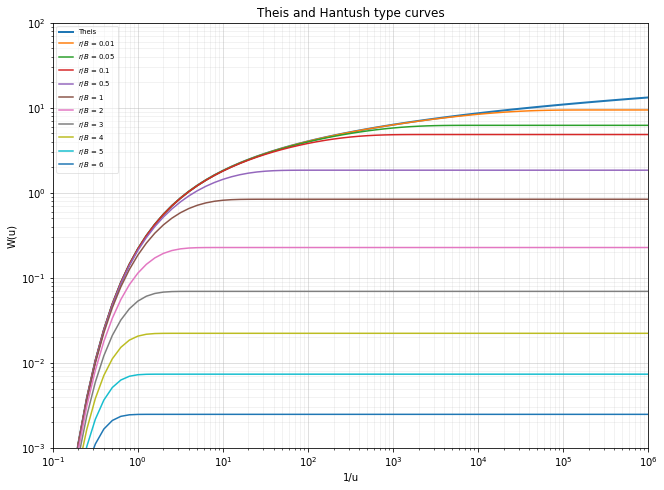

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expi
import math

def calc_u(r, S, T, t):
    """Calculate and return the dimensionless time parameter, u."""

    return r**2 * S / 4 / T / t

def calc_B(T, M1, K1):
    """Calculate and return Leakage-Factor"""

    return math.sqrt(T * M1 / K1)
    
def calc_rho(r, B):
    """Calculate and return r/B"""

    return r/B
    
def W(u): return  -expi(-u)  # Theis

def wh(u, rho):
    """Returns Hantush's well function values

    Note: works only for scalar values of u and rho

    Parameters:
    -----------
    u : scalar  (u = r^2 * S / (4 * T * t))
    rho : scalar (rho = r / B)
    Returns:
    --------
    Wh(u, rho) : Hantush well function value for (u, rho)
    """
    try:
        u = float(u)
        rho = float(rho)
    except:
        print("u and rho must be scalars.")
        raise ValueError()

    LOGINF = 2
    y = np.logspace(np.log10(u), LOGINF, 1000)
    ym = 0.5 * (y[:-1]+  y[1:])
    dy = np.diff(y)
    w = np.sum(np.exp(-ym - (rho / 2)**2 / ym ) * dy / ym)
    return w


def Wh(U,Rho):
    """Returns multiple values of Hantush's well function.

    Parameters:
    -----------
    U : ndarray with values of u
    Rho : ndarray with values of rho

    Returns:
    --------
    well function values for all combinations of U and Rho in an ndarray of shape (Nrho, Nu)
    """
    
    U   = np.array(U,   dtype=float).ravel()  # converts U to shape ([)1, Nu)
    Rho = np.array(Rho, dtype=float).ravel()  # convers V to shape (Nr, 1)
    w = np.zeros((len(Rho), len(U))) *  np.NaN     # initialize array w of shape [Nr, Nu]
    for iu, u in enumerate(list(U)):
        for ir, rho in enumerate(Rho):
            w[ir, iu] = wh(u, rho)
    return w


def hantush_drawdown(t, S, T, Q, r, M1, K1):
    """Calculate and return the drawdown s(u).

    S is the aquifer storage coefficient,
    T is the transmissivity (m2/s),
    r is the distance from the well (m), and
    Q is the pumping rate (m3/s).

    """

    U = calc_u(r, S, T, t)
    B = calc_B(T,M1,K1)
    Rho = calc_rho(r,B)
    s_hantush = Q/4/np.pi/T * Wh(U, Rho)
    return s_hantush



# Plot typecurves for different values of r/B (Rho)

Rho = [0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4, 5, 6]
U = np.logspace(-7, 1, 81)
w = Wh(U, Rho)

def cm2inch(value):
    return value/2.54

def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)


fig = plt.figure(figsize=(cm2inch(21), cm2inch(15)))

ax = fig.add_subplot(111)
set_size(cm2inch(21), cm2inch(15))
ax.set(xlabel='1/u', ylabel='W(u)', xscale='log', yscale='log',
       xlim=(1e-1,1e6), ylim=(1e-3,1e2),
      title='Theis and Hantush type curves')

ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)


ax.plot(1/U, W(U), label='Theis', linewidth=2)

for ir, rho in enumerate(Rho):
    label = r"$r/B$ = {:g}".format(rho)
    ax.plot(1/U, w[ir,:], label=label)
ax.legend(loc='best', framealpha=0.5, fontsize='x-small')

plt.show()

Let's simulate a curve for $s(t)$ for a fixed distance from the well, $r=10\;\mathrm{m}$, and pumping rate $Q = 0.002\;\mathrm{m^3/s}$ for a well with parameters $S = 0.001$ and $T = 0.001\;\mathrm{m^2/s}$. $M'$ and $K'$ for the semi-confined layer are $M' = 3\;\mathrm{m}$ and $K' = 1e-5\;\mathrm{m/s}$.

We'll add a bit of synthetic normally-distributed noise to get some realistic data simulating measurement errors (since the noise is random, slightly different values will be produced each time you run the code).

In [2]:
Q = 0.002       # Pumping rate from well (m3/s)
r = 10          # Distance from well (m)
S, T = 0.001, 0.001  # Storage Coefficient (-) and Transmissivity (m2/s)
M1, K1 = 3, 1e-5     # Saturated Thickness (m) and Hydraulic Conductivity (m/s) of confining layer

# Time grid, seconds
t = np.array([120, 160, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000, 2400, 2800])

# Calculate drawdown
s = hantush_drawdown(t, S, T, Q, r, M1, K1)

# Add some noise
noise_sd = 5.e-3
s += s * noise_sd * np.random.randn(s.shape[0])
print(s)

[[0.15896914 0.18324752 0.20040881 0.2263457  0.23990095 0.24754735
  0.25206571 0.25482051 0.25653834 0.2576279  0.2583282  0.25908127
  0.25940881 0.25955467 0.25962078 0.25965115 0.25967184 0.2596764 ]]


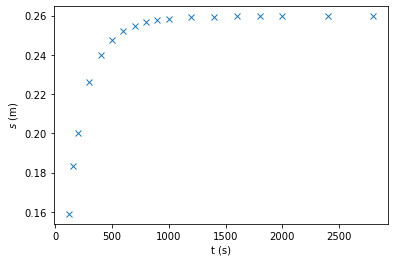

In [3]:
# Plot the generated data

s = s.reshape(18,) # change for different numbers of time steps
plt.plot(t, s, 'x')
plt.xlabel("t (s)")
plt.ylabel("$s$ (m)")
plt.show()

## Fitting the data

### Nonlinear least squares fit

The full Theis or Hantush equation can only be fit with a nonlinear routine such as [`scipy.optimize.curve_fit`](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.curve_fit.html) or [`scipy.optimize import leastsq`](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.leastsq.html). `curve_fit` can fit a function directly; it calls `leastsq` which minimizes the sum of squares of a set of equations: in this context, the residuals between the observed data and modelled $s(t)$.

`curve_fit` does not need an initial guess for the fit parameters (it sets them equal to 1 if none is provided, which may or may not be appropriate depending on the function). The function to be fit must take the independent variable as its first argument (here, $t$) and the parameters to be fit as the remaining arguments. Since we don't want to fit $Q$, $r$ and $r/B$, we'll define a wrapper function to pick them up in global scope and send them to `hantush_drawdown` which requires them.

T = 0.001 m2/s
S = 0.001 m2/s
rms residual = 1.3918233402224019e-05


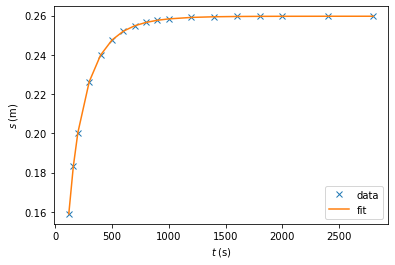

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expi
import math 
from math import inf
from math import exp
from scipy.integrate import quad
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore')

def Integrand(y):
        # integral term for the Hantush well function
        B = r/Rho
        x = np.exp(-y - r**2/(4.*B**2*y))/y
        return x

def W(u):
        # Hantush well function
        x = quad(Integrand, u, +np.inf)[0]
        return x

        
def hantush_drawdown_fit(t, S, T, Q, r, Rho):
        s = np.zeros(len(t), float)
        for i, t in enumerate(t):        
            u = calc_u(r, S, T, t)
            s[i] = Q/(4*math.pi*T) * W(u)
        return s


def hantush_func(t, S, T):
    return hantush_drawdown_fit(t, S, T, Q, r, Rho)

# We use the Rho for our generated values above
Rho = 0.577

popt, pcov = curve_fit(hantush_func, t, s)
Sfit, Tfit = popt
print('T = %.3f m2/s' %(Tfit))
print('S = %.3f m2/s' %(Sfit))

hantush_fit = hantush_drawdown_fit(t, Sfit, Tfit, Q, r, Rho)
rms_resid = np.sqrt(np.sum((s - hantush_fit)**2))
print('rms residual =', rms_resid)

plt.plot(t, s, 'x', label='data')
plt.plot(t, hantush_fit, label='fit')
plt.xlabel(r'$t\;\mathrm{(s)}$')
plt.ylabel(r'$s\;\mathrm{(m)}$')
plt.legend(loc=4)
plt.show()


We see a very good fit with $S$ and $T$ being nearly the exact values we used for the generation of the data.

#### Analysing a real world pumping test in a semi-confined aquifer

If we want to analyse a real world test, we must replace the synthetic data values we created above with the real values, along with the correct pumping rate $Q$ and distance to pumping well $r$. Morover, since we do not know the value of $r/B$, we have to check different r/B values. We first repeat the curve fit from above, assuming the values for $s$ and $t$ were measured values, and we did not know $r/B$.

Test fit for r/B = 0.01:
T = 3.01e-01 m2/s
S = -4.26e-04 m2/s
rms residual = 2.5529136079156407
Test fit for r/B = 0.05:
T = 3.15e-03 m2/s
S = 1.75e-04 m2/s
rms residual = 0.052754962834186035
Test fit for r/B = 0.10:
T = 2.54e-03 m2/s
S = 2.48e-04 m2/s
rms residual = 0.06108906834961504
Test fit for r/B = 0.50:
T = 1.04e-03 m2/s
S = 4.21e-04 m2/s
rms residual = 0.3147228678561802
Test fit for r/B = 1.00:
T = 4.83e-04 m2/s
S = 3.72e-04 m2/s
rms residual = 0.4107818422896057
Test fit for r/B = 2.00:
T = 1.33e-04 m2/s
S = 1.96e-04 m2/s
rms residual = 0.4923444298056919
Test fit for r/B = 3.00:
T = 4.11e-05 m2/s
S = 8.82e-05 m2/s
rms residual = 0.5326388069664707
Test fit for r/B = 4.00:
T = 1.33e-05 m2/s
S = 3.74e-05 m2/s
rms residual = 0.5579092771443392
Test fit for r/B = 5.00:
T = 4.42e-06 m2/s
S = 1.54e-05 m2/s
rms residual = 0.5756202442402343
Test fit for r/B = 6.00:
T = 1.50e-06 m2/s
S = 6.20e-06 m2/s
rms residual = 0.5888075280381853
Result of curve fitting:
Best fit for r/B = 0.

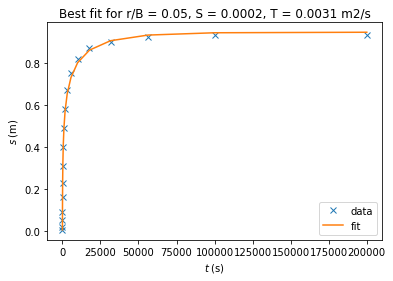

In [10]:
Rho = np.array([0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4, 5, 6]) # Define values for r/B to be checked

best_rms = 1000 # set to high initial value
best_S = 0
best_T = 0

for x in Rho:
    Rho = x
    print("Test fit for r/B = %.2f:" %Rho)
    popt, pcov = curve_fit(hantush_func, t, s, maxfev=1000)
    Sfit, Tfit = popt
    print('T = %.2e m2/s' %(Tfit))
    print('S = %.2e m2/s' %(Sfit))
    hantush_fit = hantush_drawdown_fit(t, Sfit, Tfit, Q, r, Rho)
    rms_resid = np.sqrt(np.sum((s - hantush_fit)**2))
    print('rms residual =', rms_resid)
     
    if rms_resid < best_rms:
        best_rms = rms_resid
        best_Rho = Rho
        best_S = Sfit
        best_T = Tfit
        best_hantush_fit = hantush_fit

print('Result of curve fitting:')
print('Best fit for r/B = %.2f, S = %.4e, T = %.4e m2/s' %(best_Rho, best_S, best_T))

plt.plot(t, s, 'x', label='data')
plt.plot(t, best_hantush_fit, label='fit')
plt.xlabel(r'$t\;\mathrm{(s)}$')
plt.ylabel(r'$s\;\mathrm{(m)}$')
plt.legend(loc=4)
plt.title('Best fit for r/B = %.2f, S = %.4f, T = %.4f m2/s' %(best_Rho, best_S, best_T))
plt.show()


The best fit should result for $r/B$ of 0.5 or 1.0 (depending on the random noise that was added above), which corresponds well to the real, known value of 0.577. Also the values for $S$ and $T$ are OK, so the method seems to work fine.

We then repeat the curve fit with the values from the excercise: $Q$ = 6 L/s, $r$ = 40 m and the measured values for $t$ and $s$:

In [6]:
# Values from excercise: 

Q = 0.006       # Pumping rate from well (m3/s)
r = 40          # Distance from well (m)

t = np.array([10,18,32,56,100,178,316,562,1000,1778,3162,5623,10000,17780,31629,56230, 100000, 200000])
s = np.array([0.005,0.02,0.05,0.09,0.16,0.23,0.31,0.4,0.49,0.58,0.67,0.75,0.82,0.87,0.9,0.92, 0.93, 0.93])


We use the same curve fit from above again:

Test fit for r/B = 0.01:
T = 3.007e-01 m2/s
S = -4.258e-04 m2/s
rms residual = 2.5529136079156407
Test fit for r/B = 0.05:
T = 3.147e-03 m2/s
S = 1.753e-04 m2/s
rms residual = 0.052754962834186035
Test fit for r/B = 0.10:
T = 2.544e-03 m2/s
S = 2.479e-04 m2/s
rms residual = 0.06108906834961504
Test fit for r/B = 0.50:
T = 1.035e-03 m2/s
S = 4.211e-04 m2/s
rms residual = 0.3147228678561802
Test fit for r/B = 1.00:
T = 4.830e-04 m2/s
S = 3.716e-04 m2/s
rms residual = 0.4107818422896057
Test fit for r/B = 2.00:
T = 1.334e-04 m2/s
S = 1.956e-04 m2/s
rms residual = 0.4923444298056919
Test fit for r/B = 3.00:
T = 4.113e-05 m2/s
S = 8.823e-05 m2/s
rms residual = 0.5326388069664707
Test fit for r/B = 4.00:
T = 1.330e-05 m2/s
S = 3.744e-05 m2/s
rms residual = 0.5579092771443392
Test fit for r/B = 5.00:
T = 4.421e-06 m2/s
S = 1.538e-05 m2/s
rms residual = 0.5756202442402343
Test fit for r/B = 6.00:
T = 1.495e-06 m2/s
S = 6.196e-06 m2/s
rms residual = 0.5888075280381853
Result of curve fitting:
B

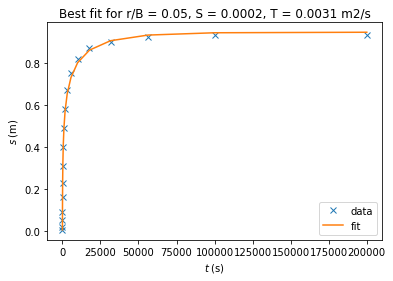

In [11]:
Rho = np.array([0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4, 5, 6]) # Define values for r/B to be checked

best_rms = 1000 # set to high initial value
best_S = 0
best_T = 0

for x in Rho:
     Rho = x
     print("Test fit for r/B = %.2f:" %Rho)
     popt, pcov = curve_fit(hantush_func, t, s, maxfev=1000)
     Sfit, Tfit = popt
     print('T = %.3e m2/s' %(Tfit))
     print('S = %.3e m2/s' %(Sfit))
     hantush_fit = hantush_drawdown_fit(t, Sfit, Tfit, Q, r, Rho)
     rms_resid = np.sqrt(np.sum((s - hantush_fit)**2))
     print('rms residual =', rms_resid)
     
     if rms_resid < best_rms:
         best_rms = rms_resid
         best_Rho = Rho
         best_S = Sfit
         best_T = Tfit
         best_hantush_fit = hantush_fit
 
print('Result of curve fitting:')
print('Best fit for r/B = %.2f, S = %.4f, T = %.4f m2/s' %(best_Rho, best_S, best_T))

plt.plot(t, s, 'x', label='data')
plt.plot(t, best_hantush_fit, label='fit')
plt.xlabel(r'$t\;\mathrm{(s)}$')
plt.ylabel(r'$s\;\mathrm{(m)}$')
plt.legend(loc=4)
plt.title('Best fit for r/B = %.2f, S = %.4f, T = %.4f m2/s' %(best_Rho, best_S, best_T))
plt.show()


The fitted curve seems to fit fairly OK. However, if we compare the result to the graphical solution (see pdf), we see some small differences (the values there were fitted to the type curve for r/B = 0.1), which can be attributed to inaccuracies of the manual graphical fitting. If we would like to have a more exact result, we can also check more values for $r/B$ within the range of the values with the smallest rms from above. Since the rms was lowest for $r/B$ of 0.05 and 0.1, let's check some more values within this range:

Test fit for r/B = 0.04:
T = 3.324e-03 m2/s
S = 1.573e-04 m2/s
rms residual = 0.0848781074870813
Test fit for r/B = 0.05:
T = 3.147e-03 m2/s
S = 1.753e-04 m2/s
rms residual = 0.052754962834186035
Test fit for r/B = 0.06:
T = 2.995e-03 m2/s
S = 1.921e-04 m2/s
rms residual = 0.027466973450547067
Test fit for r/B = 0.07:
T = 2.863e-03 m2/s
S = 2.076e-04 m2/s
rms residual = 0.01615018802059188
Test fit for r/B = 0.08:
T = 2.745e-03 m2/s
S = 2.220e-04 m2/s
rms residual = 0.028091484884530633
Test fit for r/B = 0.09:
T = 2.640e-03 m2/s
S = 2.354e-04 m2/s
rms residual = 0.04490729682081384
Test fit for r/B = 0.10:
T = 2.544e-03 m2/s
S = 2.479e-04 m2/s
rms residual = 0.06108906834961504
Result of curve fitting:
Best fit for r/B = 0.07, S = 0.0002, T = 0.0029 m2/s


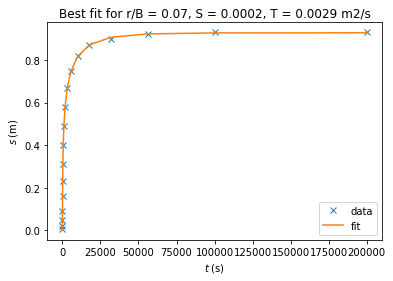

In [12]:
Rho = np.array([0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]) # Define values for r/B to be checked

best_rms = 1000 # set to high initial value
best_S = 0
best_T = 0

for x in Rho:
     Rho = x
     print("Test fit for r/B = %.2f:" %Rho)
     popt, pcov = curve_fit(hantush_func, t, s, maxfev=1000)
     Sfit, Tfit = popt
     print('T = %.3e m2/s' %(Tfit))
     print('S = %.3e m2/s' %(Sfit))
     hantush_fit = hantush_drawdown_fit(t, Sfit, Tfit, Q, r, Rho)
     rms_resid = np.sqrt(np.sum((s - hantush_fit)**2))
     print('rms residual =', rms_resid)
     
     if rms_resid < best_rms:
         best_rms = rms_resid
         best_Rho = Rho
         best_S = Sfit
         best_T = Tfit
         best_hantush_fit = hantush_fit
 
print('Result of curve fitting:')
print('Best fit for r/B = %.2f, S = %.4f, T = %.4f m2/s' %(best_Rho, best_S, best_T))

plt.plot(t, s, 'x', label='data')
plt.plot(t, best_hantush_fit, label='fit')
plt.xlabel(r'$t\;\mathrm{(s)}$')
plt.ylabel(r'$s\;\mathrm{(m)}$')
plt.legend(loc=4)
plt.title('Best fit for r/B = %.2f, S = %.4f, T = %.4f m2/s' %(best_Rho, best_S, best_T))
plt.show()


We now see the best fit for $r/B$ of 0.07, which is about in the middle of 0.05 and 0.1, and values of $T$ and $S$ rather similar to the graphical solution (which was not so bad in the end...). We also see, that the values for $T$ and $S$ did not change much to the iteration before. In practice, to test the "standard range" for $r/B$ is normally good enough.